# Projet Fraude 



In [1]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report
%matplotlib inline

In [2]:
data = pd.read_csv('./FraudData/Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
data.head()
#target --> class : 1 Fraud | 0 ok 

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
address2country = pd.read_csv('./FraudData/IpAddress_to_Country.csv')
address2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [4]:
#jointure on IP 
countries = []
for i in range(len(data)):
    ip_address = data.loc[i, 'ip_address']
    tmp = address2country[(address2country['lower_bound_ip_address'] <= ip_address) &
                          (address2country['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')
 
data['country'] = countries
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [5]:
#timediff 
time_diff = data['purchase_time'] - data['signup_time']
time_diff = time_diff.apply(lambda x: x.seconds)
data['time_diff'] = time_diff

In [6]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461


In [7]:
# Check user number for unique devices --> max device/id : 20
device_num = data[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns={'user_id': 'device_num'})
data = data.merge(device_num, how='left', on='device_id')
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1


In [8]:
# Check user number for unique ip_address
ip_num = data[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()
ip_num = ip_num.rename(columns={'user_id': 'ip_num'})
data = data.merge(ip_num, how='left', on='ip_address')

In [9]:
# Signup day and week
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)
# Purchase day and week
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)

In [10]:
# Define features and target to be used
columns = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num', 'class']
data = data[columns]
data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,13882,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1,12,12,1
3,1,18,0,19,44,SEO,Safari,M,41,NA,60085,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,41461,1,1,0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151112 entries, 0 to 151111
Data columns (total 14 columns):
signup_day        151112 non-null int64
signup_week       151112 non-null int64
purchase_day      151112 non-null int64
purchase_week     151112 non-null int64
purchase_value    151112 non-null int64
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
country           151112 non-null object
time_diff         151112 non-null int64
device_num        151112 non-null int64
ip_num            151112 non-null int64
class             151112 non-null int64
dtypes: int64(10), object(4)
memory usage: 17.3+ MB


In [12]:
#encodage 
from sklearn.preprocessing import LabelEncoder
X = data[columns[:-1]]
y = data['class']
source_labelEncoder = LabelEncoder()
browser_labelEncoder = LabelEncoder()
sex_labelEncoder = LabelEncoder()
country_labelEncoder = LabelEncoder()
X['source'] = source_labelEncoder.fit_transform(data['source'])
X['browser'] = source_labelEncoder.fit_transform(data['browser'])
X['sex'] = source_labelEncoder.fit_transform(data['sex'])
X['country'] = source_labelEncoder.fit_transform(data['country'])

In [13]:
#dummies
X = pd.get_dummies(X)
#print(X)
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("Shape du dataset d'entrainement : {} | Shape du dataset de test : {}".format(X_train.shape, X_test.shape))

Shape du dataset d'entrainement : (105778, 13) | Shape du dataset de test : (45334, 13)


In [14]:
#RandomForest
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [15]:
#cvs
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
scores = cross_val_score(clf, X_train, y_train, scoring='accuracy').mean()
print("L'accuracy moyenne pour 10 'fold cross validation' est {}%".format(round(scores*100,2)))

L'accuracy moyenne pour 10 'fold cross validation' est 95.57%


In [16]:
#features importance 
feature_imp = pd.Series(clf.feature_importances_,index=columns[:-1]).sort_values(ascending=False)
feature_imp

time_diff         0.257335
purchase_week     0.162969
ip_num            0.128423
device_num        0.115033
signup_week       0.070226
purchase_value    0.064069
age               0.054634
country           0.040700
signup_day        0.031324
purchase_day      0.029825
browser           0.021963
source            0.012931
sex               0.010569
dtype: float64

Text(0.5, 1.0, 'Visualizing Important Features')

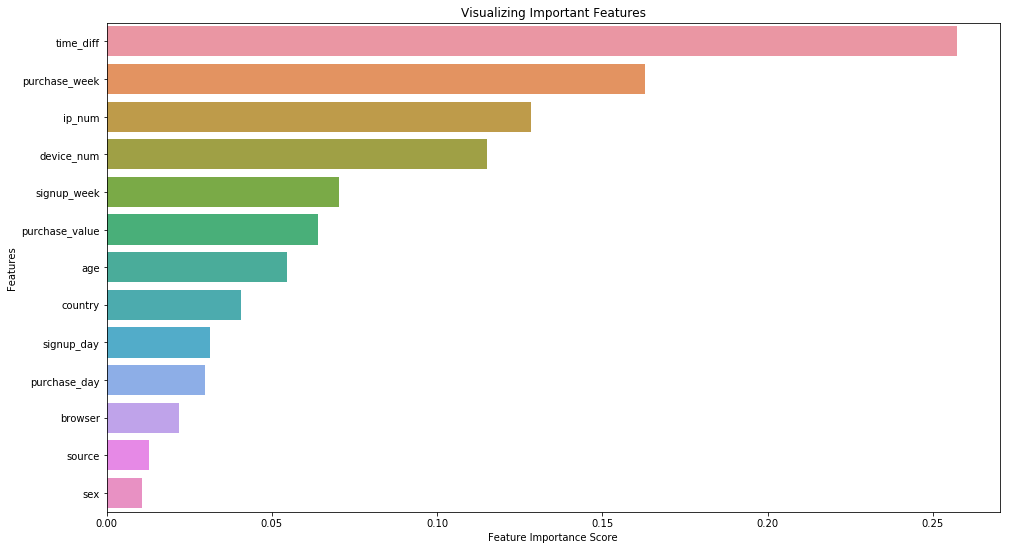

In [17]:
#plot
plt.figure(figsize=(16,9))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [18]:
#test_true= y_test.values
#type(y_pred)==type(y_test.values)
test_fpr, test_tpr, _ = roc_curve(y_test.values, y_pred)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

# Classification report
print(classification_report(y_true=y_test.values, y_pred=(y_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41177
           1       1.00      0.55      0.71      4157

   micro avg       0.96      0.96      0.96     45334
   macro avg       0.98      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



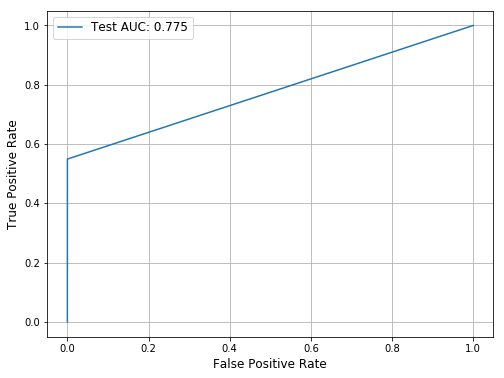

In [19]:
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
#ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
#ax.plot(test_fpr, test_tpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

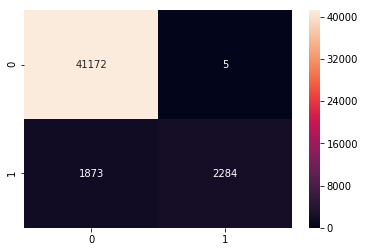

In [27]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='g')

In [21]:
#entrainement sur certaine features 
cols = ['device_num', 'time_diff', 'purchase_week', 'ip_num']
X_train, X_test, y_train, y_test = train_test_split(X[cols], y, test_size=0.3, random_state=0)
print("Shape du dataset d'entrainement : {} | Shape du dataset de test : {}".format(X_train.shape, X_test.shape))

Shape du dataset d'entrainement : (105778, 4) | Shape du dataset de test : (45334, 4)


In [22]:
#vs logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
scores = cross_val_score(lr, X_train, y_train, scoring='accuracy').mean()
print("L'accuracy moyenne pour 10 'fold cross validation' est {}%".format(round(scores*100,2)))

L'accuracy moyenne pour 10 'fold cross validation' est 95.39%
